# Generation of custom datasets for prediction data and embedding visualization

## Load General Dependencies

In [1]:
# Autoreload is not strictly necessary
# but helpful for development purposes
# as it automates the reload of python files
%load_ext autoreload
%autoreload 2

In [2]:
import json
import time
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

from src import loading

## Load Mutation Dataset

In [3]:
data = loading.load_dataset('../TestingBackend/data/flask_full.pkl')

## Load Test.json
Because the version of the mutation testing dataset and the current repository version can be different,
a current output of pytest in json format is used to keep both in sync:

It can be simply generated by using pytest-json:
Open the directory of the repository and execute:
```
. venv/bin/activate
pip install pytest-json
pytest --json=report.json
```

Currently, the sync this is done by matching the name of the tests.

In [7]:
# Load into tests
with open('../flask/report.json') as file:
    parsed_json = json.load(file)
    tests = parsed_json['report']['tests']

In [8]:
test_full_names = []
for test in tests:
    test_full_names.append(test['name'])

def filter_nonexistent_tests(data, full_names):
    length = len(data)
    filtered_data = data[data['full_name'].isin(full_names)]
    filtered_length = len(filtered_data)
    print(f"Filtered for full names. Deleted {length - filtered_length} entries ({(length-filtered_length) / length * 100}%)")
    return filtered_data

data = filter_nonexistent_tests(data, test_full_names)

Filtered for full names. Deleted 26656 entries (2.7823443881838044%)


In [9]:
name_and_number_of_failures = data.groupby(['outcome', 'full_name']).count().loc['outcome' == False]['mutant_id']

In [10]:
# Store Mutant Failures in tests
for test in tests:
    test['mutant_failures'] = 0
    if test['name'] in name_and_number_of_failures:
        test['mutant_failures'] = int(name_and_number_of_failures.at[test['name']])

## Train Prediction Model

In [11]:
# Load additional Dependencies
from src import preprocessing
from sklearn import tree

In [12]:
# Apply preprocessing steps to make sure data does not contain invalid information
preprocessing.cleanse_data(data)
preprocessing.add_edit_distance_feature(data)
data = preprocessing.filter_NaN_values('flask', data)

flask: Kicked out 0 values from 931385 total values. (0.0%) (NaN value filter)


In [13]:
#encoded_column_names = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
encoded_column_names = ["modified_file_path"]
dangerous_features = ['duration', 'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration', 'teardown_outcome', 'teardown_duration']
unencoded_features = ['repo_path', 'full_name']

In [14]:
# Use a DecisionTreeClassifier
predictor = tree.DecisionTreeClassifier()

Here, additional features can be selected for the predictor.
It is important that these features can also be generated on the fly by the TestingBackend.
Adding a new features requires to add it here, and then activate it in the TestingBackend.

In [15]:
selected_features = [
    # Required Features (necessary for process)
    'test_id', 'outcome', 'mutant_id',

    # Basic features:
    'modified_file_path', 'line_number_changed',
]

encoded_data, encoder = preprocessing.encode_columns(data, encoded_column_names)

encoded_data = encoded_data.drop(dangerous_features, axis=1).drop(unencoded_features, axis=1)[selected_features].copy()
   
X_train, y_train, X_test, y_test = preprocessing.train_test_split(encoded_data)
predictor.fit(X_train.drop(['mutant_id'],axis=1), y_train)

print("Score: " + str(predictor.score(X_test.drop(['mutant_id'], axis=1), y_test)))

Score: 0.9074096799985125


# Embedding from Covariances
In the embedding view in the TestingPlugins, the tests are mapped to a xy-plane based on their covariances. The embedding algorithm can be customized here.

In [18]:
# Load additional Dependencies
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap

In [19]:
def compute_and_show_embedding(model, data):
    pivot = data.set_index('mutant_id').pivot(columns='test_id', values='outcome')
    pivot = pivot.astype('bool')

    embedding = model.fit_transform(pivot.cov())
    plt.scatter(embedding[:, 0], embedding[:, 1])
    plt.axis('equal')
    return embedding, pivot

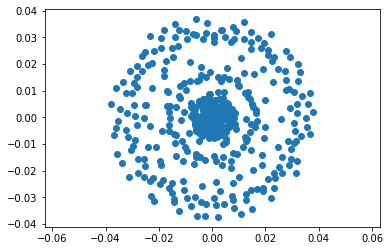

In [20]:
# MDS Embedding Model
embedding, pivot = compute_and_show_embedding(MDS(n_components=2, dissimilarity='precomputed', random_state=42), data)

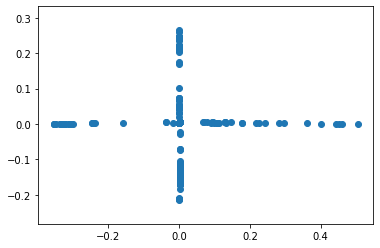

In [21]:
# ISOMap Embedding Model
embedding, pivot = compute_and_show_embedding(Isomap(n_components=2), data)

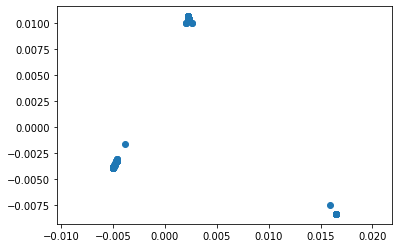

In [22]:
# Spectral Embedding Model
embedding, pivot = compute_and_show_embedding(SpectralEmbedding(n_components=2), data)

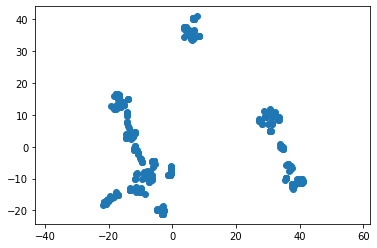

In [23]:
# TSNE Embedding Model
embedding, pivot = compute_and_show_embedding(TSNE(n_components=2, random_state=42), data)

In [24]:
# Store the xy coordinates of the embedding in `tests`
# Which model is used is dependent on which cell of the embeddings get's executed last
xy = pd.DataFrame(embedding, index=list(pivot.columns))
for test in tests:
    if test['name'] in xy.index:
        test['x'] = float(xy.at[test['name'], 0])
        test['y'] = float(xy.at[test['name'], 1])

## Store files to disk

In [25]:
# JSON
with open('test_visualization_data.json', 'w') as file:
    json.dump(tests, file)

In [26]:
# Joblib Files (Predictor Model)
name = 'flask_decisiontree.joblib'
joblib.dump({'predictor': predictor, 'encoder': encoder, 'test_ids_to_test_names': data.groupby('test_id').sample().set_index('test_id')['full_name']}, name)

['flask_decisiontree.joblib']

These files now need to be loaded by the backend, by customizing the paths in `TestingBackend/config.cfg`